#Libraries

In [10]:
!pip install -r requirements.txt -q

^C
ERROR: Operation cancelled by user


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import datetime as dt

from fast_ml.model_development import train_valid_test_split

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau

from PIL import Image
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

#Data Loading and Configurations

In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except ModuleNotFoundError:
  print("running locally")
  on_colab = False
else:
  print("running on colab")
  on_colab = True

Mounted at /content/drive
running on colab


In [8]:
def find_directory_by_name(root_directory, target_directory_name):
    # Check if the root directory itself matches the target directory name
    if os.path.basename(root_directory) == target_directory_name:
        return os.path.abspath(root_directory)

    # Search within the root directory tree
    for dirpath, dirnames, filenames in os.walk(root_directory):
        if target_directory_name in dirnames:
            return os.path.join(dirpath, target_directory_name)

    return None  # If directory is not found

In [11]:
MAIN_PATH = find_directory_by_name(os.getcwd(), "Pneumothorax Detection in Chest X-rays")
DATASET_PATH = os.path.join(MAIN_PATH, "siim-acr-pneumothorax")
IMG_PATH = os.path.join(DATASET_PATH, 'png_images')
MASK_PATH = os.path.join(DATASET_PATH, 'png_masks')

CONF = {
    "img_height" : 512,
    "img_width" : 512,
    "img_channel" : 3,
    "batch_size" : 32,
    "test_batch_size" : 128,
    "mean" : 0.5,
    "std" : 0.5,
    "learning_rate" : 1e-3,
    "device" : "cuda",
    "epochs" : 25
}


In [ ]:
train_df = pd.read_csv(os.path.join(DATASET_PATH, 'stage_1_train_images.csv'))
test_df = pd.read_csv(os.path.join(DATASET_PATH, 'stage_1_test_images.csv'))

In [ ]:
train_df.head(3)

,new_filename,ImageId,has_pneumo
0,0_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,0
1,1_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,0
2,2_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,1


In [ ]:
train_df['has_pneumo'].value_counts()

,count
has_pneumo,
0,8296
1,2379


In [ ]:
test_df['has_pneumo'].value_counts()

,count
has_pneumo,
0,1082
1,290


#Data Preprocessing and Augmentation

In [ ]:

# Dataset class to handle loading of images and masks
class PneumothoraxDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.image_filenames = os.listdir(image_dir)

  def __len__(self):
    return len(self.image_filenames)

  def __getitem__(self, idx):
    img_name = self.image_filenames[idx]
    img_path = os.path.join(self.image_dir, img_name)
    mask_path = os.path.join(self.mask_dir, img_name)

    # Open the image and mask as PIL images
    image = Image.open(img_path)
    mask = Image.open(mask_path)

    if self.transform:
      seed = torch.randint(0, 2**32, (1,)).item()
      torch.manual_seed(seed)
      image = self.transform(image)
      image = transforms.Normalize(mean=CONF['mean'], std=CONF['std'])(image)
      torch.manual_seed(seed)
      mask = self.transform(mask)

    image = torch.cat([image, image, image], dim=0)

    label = 1 if len(np.unique(mask)) > 1 else 0

    return image, mask, label  # Returning the image and binary label, and mask


In [ ]:
# Define the transformations (including resizing, augmentations, and normalization)
transform = transforms.Compose([
    transforms.Resize((CONF['img_height'], CONF['img_width']), interpolation=transforms.InterpolationMode.NEAREST),  # Resize images to 512x512 pixels
    transforms.RandomRotation(15),  # Random rotation
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Random brightness/contrast
    transforms.ToTensor(),  # Convert images to Tensor

])

no_transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
# Create the dataset
dataset = PneumothoraxDataset(IMG_PATH, MASK_PATH, transform=no_transform)

In [ ]:
# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Create data loaders for each set
def get_data_loaders(train_dataset,val_dataset,test_dataset, sampler=None):
  train_loader = DataLoader(train_dataset, batch_size=CONF['batch_size'], num_workers=4, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=CONF['batch_size'], num_workers=4, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=CONF['test_batch_size'], num_workers=4, shuffle=True)

  return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_data_loaders(train_dataset,val_dataset,test_dataset)

#Data Visualization

In [ ]:
def visualize_samples(dataset, num_samples=12, grid_size=(4, 3), offset=0):
    rows, cols = grid_size
    fig, axs = plt.subplots(rows, cols * 2, figsize=(12, rows * 4))

    for i in range(num_samples):
        row, col = divmod(i, cols)
        image, mask, label = dataset[i + offset]  # Get image and mask pair

        # Convert tensor to image for plotting
        image = F.to_pil_image(image)
        mask = F.to_pil_image(mask)

        # Plot image
        axs[row, col * 2].imshow(image, cmap='gray')
        axs[row, col * 2].set_title(f"X-ray Image {i + 1}")
        axs[row, col * 2].axis('off')

        # Plot mask
        axs[row, col * 2 + 1].imshow(mask, cmap='gray')
        axs[row, col * 2 + 1].set_title(f"Mask {i + 1} " + ("pn" if label else "no pn"))
        axs[row, col * 2 + 1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# # Visualize 5 samples from the training dataset
# visualize_samples(train_dataset, offset=15)

In [ ]:
#apply transformation
dataset.transform = transform

In [ ]:
#regenerate data with the new transformations
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
train_loader, val_loader, test_loader = get_data_loaders(train_dataset,val_dataset,test_dataset)

In [ ]:
# Check a batch of images and masks
for images, masks, labels in train_loader:
    print(f"Image batch dimensions: {images.shape}")
    print(f"Mask batch dimensions: {masks.shape}")
    print(f"Mask example: {masks[0]}")
    print(f"Label: {labels[0]}")
    break

Image batch dimensions: torch.Size([32, 3, 512, 512])
Mask batch dimensions: torch.Size([32, 1, 512, 512])
Mask example: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Label: 0


In [ ]:
# visualize_samples(train_dataset, offset=15)

#CNN Implementation for Classification

## Model and Schedular Declaration

In [ ]:
def create_model(encoder_name, encoder_weights, in_channels, classes, activation):
    model = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes, activation=activation)
    return model

def create_optimizer(model, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return optimizer

def create_scheduler(optimizer, factor=0.5, patience=3):
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, verbose=True)
    return scheduler


## Loss Function Declaration

In [ ]:
def dice_loss(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = 1 - (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def bce_loss(pred, target):
    return nn.BCEWithLogitsLoss()(pred, target)

def focal_loss(pred, target, alpha=0.8, gamma=2):
    bce = nn.BCEWithLogitsLoss(reduction='none')(pred, target)
    pred_prob = torch.sigmoid(pred)
    pt = torch.where(target == 1, pred_prob, 1 - pred_prob)  # pt is the probability of the correct class
    loss = alpha * (1 - pt) ** gamma * bce
    return loss.mean()

def combined_loss(pred, target, alpha=0.5, beta=0.3, gamma=0.2):
    return alpha * bce_loss(pred, target) + beta * dice_loss(pred, target) + gamma * focal_loss(pred, target)


## Train Metrics

In [ ]:
def accuracy_metric(pred, target, threshold=0.5):
    pred = torch.sigmoid(pred) > threshold
    correct = (pred == target).float()
    acc = correct.sum() / correct.numel()
    return acc

def iou_metric(pred, target, threshold=0.5, smooth=1e-5):
    pred = (torch.sigmoid(pred) > threshold).long() # Convert pred to long
    target = target.long() # Convert target to long
    intersection = (pred & target).float().sum((2, 3))
    union = (pred | target).float().sum((2, 3))
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

## Train Loop

In [ ]:
def train_model(model, train_loader, val_loader, device, optimizer, scheduler, num_epochs=20, patience=5):
    best_loss = float('inf')
    patience_counter = 0
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []
    train_iou_list, val_iou_list = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        running_iou = 0.0

        for images, masks, _ in tqdm(train_loader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = combined_loss(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_acc += accuracy_metric(outputs, masks).item()
            running_iou += iou_metric(outputs, masks).item()

        train_loss = running_loss / len(train_loader)
        train_acc = running_acc / len(train_loader)
        train_iou = running_iou / len(train_loader)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        train_iou_list.append(train_iou)

        # Validation
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        val_iou = 0.0

        with torch.no_grad():
            for images, masks, _ in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = combined_loss(outputs, masks)

                val_loss += loss.item()
                val_acc += accuracy_metric(outputs, masks).item()
                val_iou += iou_metric(outputs, masks).item()

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_iou /= len(val_loader)

        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        val_iou_list.append(val_iou)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, "
              f"Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}")

        # Scheduler step
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    model.load_state_dict(best_model_wts)
    return model, train_loss_list, val_loss_list, train_acc_list, val_acc_list, train_iou_list, val_iou_list

In [ ]:
def main(train_loader, val_loader, encoder_name, encoder_weights, in_channels, classes, activation, device, num_epochs=25, lr=1e-3):
    # Create model, optimizer, and scheduler
    model = create_model(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes, activation=activation).to(device)
    optimizer = create_optimizer(model, lr)
    scheduler = create_scheduler(optimizer)

    # Train the model
    trained_model, train_loss, val_loss, train_acc, val_acc, train_iou, val_iou = train_model(model, train_loader, val_loader, device, optimizer, scheduler, num_epochs=num_epochs)
    train_history = {
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "train_iou": train_iou,
        "val_iou": val_iou,
    }

    # Save Results
    dict_save_loc = os.path.join(MAIN_PATH, "histories")
    model_save_loc = os.path.join(MAIN_PATH, "models")

    if not os.path.exists(dict_save_loc):
      os.makedirs(dict_save_loc)

    if not os.path.exists(model_save_loc):
      os.makedirs(model_save_loc)


    torch.save(trained_model, os.path.join(model_save_loc, 'Unet_' + encoder_name + '_model_pytorch_' + str(dt.datetime.now()) + '.pt'))
    pd.DataFrame.from_dict(data=train_history).to_csv(os.path.join(dict_save_loc, encoder_name + "train_history" + "_" + str(dt.datetime.now()) + ".csv"))

    return trained_model, train_history

In [ ]:
trained_model, train_history = main(train_loader,
                                    val_loader,
                                    encoder_name="resnet34",
                                    encoder_weights="imagenet",
                                    in_channels=CONF['img_channel'],
                                    classes=1,
                                    activation=None,
                                    device=CONF["device"],
                                    num_epochs=CONF['epochs'],
                                    lr=CONF['learning_rate'])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 277MB/s]
100%|██████████| 264/264 [42:21<00:00,  9.63s/it]


Epoch [1/25] - Train Loss: 0.3216, Val Loss: 0.3047, Train Acc: 0.9873, Val Acc: 0.9857, Train IoU: 0.5911, Val IoU: 0.1744


100%|██████████| 264/264 [05:28<00:00,  1.24s/it]


Epoch [2/25] - Train Loss: 0.2995, Val Loss: 0.3028, Train Acc: 0.9864, Val Acc: 0.9833, Train IoU: 0.1715, Val IoU: 0.1932


100%|██████████| 264/264 [05:30<00:00,  1.25s/it]


Epoch [3/25] - Train Loss: 0.2953, Val Loss: 0.2963, Train Acc: 0.9874, Val Acc: 0.9883, Train IoU: 0.2198, Val IoU: 0.5109


100%|██████████| 264/264 [05:29<00:00,  1.25s/it]


Epoch [4/25] - Train Loss: 0.2934, Val Loss: 0.2953, Train Acc: 0.9861, Val Acc: 0.9832, Train IoU: 0.2452, Val IoU: 0.1050


100%|██████████| 264/264 [05:27<00:00,  1.24s/it]


Epoch [5/25] - Train Loss: 0.2912, Val Loss: 0.2952, Train Acc: 0.9879, Val Acc: 0.9894, Train IoU: 0.2289, Val IoU: 0.2872


100%|██████████| 264/264 [05:28<00:00,  1.24s/it]


Epoch [6/25] - Train Loss: 0.2901, Val Loss: 0.2982, Train Acc: 0.9898, Val Acc: 0.9912, Train IoU: 0.2164, Val IoU: 0.3889


100%|██████████| 264/264 [05:27<00:00,  1.24s/it]


Epoch [7/25] - Train Loss: 0.2886, Val Loss: 0.2921, Train Acc: 0.9895, Val Acc: 0.9889, Train IoU: 0.2333, Val IoU: 0.3709


100%|██████████| 264/264 [05:26<00:00,  1.24s/it]


Epoch [8/25] - Train Loss: 0.2872, Val Loss: 0.3885, Train Acc: 0.9880, Val Acc: 0.8960, Train IoU: 0.2553, Val IoU: 0.0537


100%|██████████| 264/264 [05:26<00:00,  1.24s/it]


Epoch [9/25] - Train Loss: 0.2863, Val Loss: 0.2903, Train Acc: 0.9885, Val Acc: 0.9908, Train IoU: 0.2507, Val IoU: 0.1623


100%|██████████| 264/264 [05:27<00:00,  1.24s/it]


Epoch [10/25] - Train Loss: 0.2855, Val Loss: 0.2932, Train Acc: 0.9876, Val Acc: 0.9857, Train IoU: 0.2715, Val IoU: 0.1314


100%|██████████| 264/264 [05:27<00:00,  1.24s/it]


Epoch [11/25] - Train Loss: 0.2845, Val Loss: 0.2992, Train Acc: 0.9879, Val Acc: 0.9884, Train IoU: 0.2214, Val IoU: 0.2256


100%|██████████| 264/264 [05:28<00:00,  1.25s/it]


Epoch [12/25] - Train Loss: 0.2842, Val Loss: 0.2901, Train Acc: 0.9882, Val Acc: 0.9886, Train IoU: 0.2746, Val IoU: 0.3411


100%|██████████| 264/264 [05:29<00:00,  1.25s/it]


Epoch [13/25] - Train Loss: 0.2833, Val Loss: 0.2928, Train Acc: 0.9882, Val Acc: 0.9884, Train IoU: 0.2523, Val IoU: 0.3311


100%|██████████| 264/264 [05:28<00:00,  1.25s/it]


Epoch [14/25] - Train Loss: 0.2828, Val Loss: 0.2884, Train Acc: 0.9883, Val Acc: 0.9876, Train IoU: 0.2508, Val IoU: 0.1532


100%|██████████| 264/264 [05:26<00:00,  1.24s/it]


Epoch [15/25] - Train Loss: 0.2819, Val Loss: 0.2917, Train Acc: 0.9888, Val Acc: 0.9835, Train IoU: 0.2940, Val IoU: 0.1439


100%|██████████| 264/264 [05:28<00:00,  1.24s/it]


Epoch [16/25] - Train Loss: 0.2818, Val Loss: 0.3063, Train Acc: 0.9894, Val Acc: 0.9682, Train IoU: 0.2768, Val IoU: 0.0671


100%|██████████| 264/264 [05:29<00:00,  1.25s/it]


Epoch [17/25] - Train Loss: 0.2815, Val Loss: 0.2859, Train Acc: 0.9875, Val Acc: 0.9892, Train IoU: 0.3226, Val IoU: 0.4920


100%|██████████| 264/264 [05:30<00:00,  1.25s/it]


Epoch [18/25] - Train Loss: 0.2805, Val Loss: 0.2980, Train Acc: 0.9880, Val Acc: 0.9821, Train IoU: 0.3013, Val IoU: 0.1258


100%|██████████| 264/264 [05:30<00:00,  1.25s/it]


Epoch [19/25] - Train Loss: 0.2806, Val Loss: 0.2879, Train Acc: 0.9883, Val Acc: 0.9866, Train IoU: 0.2662, Val IoU: 0.3110


100%|██████████| 264/264 [05:30<00:00,  1.25s/it]


Epoch [20/25] - Train Loss: 0.2800, Val Loss: 0.3089, Train Acc: 0.9901, Val Acc: 0.9705, Train IoU: 0.2688, Val IoU: 0.1485


100%|██████████| 264/264 [05:26<00:00,  1.24s/it]


Epoch [21/25] - Train Loss: 0.2796, Val Loss: 0.2885, Train Acc: 0.9882, Val Acc: 0.9875, Train IoU: 0.2799, Val IoU: 0.1447


100%|██████████| 264/264 [05:26<00:00,  1.24s/it]


Epoch [22/25] - Train Loss: 0.2769, Val Loss: 0.2805, Train Acc: 0.9903, Val Acc: 0.9926, Train IoU: 0.3097, Val IoU: 0.3354


100%|██████████| 264/264 [05:27<00:00,  1.24s/it]


Epoch [23/25] - Train Loss: 0.2762, Val Loss: 0.3335, Train Acc: 0.9884, Val Acc: 0.9504, Train IoU: 0.3408, Val IoU: 0.1711


100%|██████████| 264/264 [05:28<00:00,  1.24s/it]


Epoch [24/25] - Train Loss: 0.2761, Val Loss: 0.3273, Train Acc: 0.9893, Val Acc: 0.9616, Train IoU: 0.3583, Val IoU: 0.1226


100%|██████████| 264/264 [05:28<00:00,  1.24s/it]


Epoch [25/25] - Train Loss: 0.2758, Val Loss: 0.2835, Train Acc: 0.9893, Val Acc: 0.9892, Train IoU: 0.3529, Val IoU: 0.4773


#CNN Enhancement

##Experimenting with different CNN architectures

In [ ]:
!pip install --upgrade certifi

import ssl

# Create a new SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
encoders = [("vgg16", "imagenet"),("inceptionresnetv2", "imagenet+background"), ("xception","imagenet")]

for encoder_name, encoder_weights in encoders:
  print('Training model Unet with' + encoder_name + ":")
  model, _ = main(train_loader,
                  val_loader,
                  encoder_name=encoder_name,
                  encoder_weights=encoder_weights,
                  in_channels=CONF['img_channel'],
                  classes=1,
                  activation=None,
                  device=CONF["device"],
                  num_epochs=CONF['epochs'],
                  lr=CONF['learning_rate'])
  print("................................Finished...................................")
  # Delete the model and free its memory
  del model
  # Empty the CUDA cache
  torch.cuda.empty_cache()

  # Perform garbage collection
  gc.collect()

  # Check GPU memory usage
  print(torch.cuda.memory_allocated())
  print(torch.cuda.memory_reserved())

Training model Unet withinceptionresnetv2:


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to /root/.cache/torch/hub/checkpoints/inceptionresnetv2-520b38e4.pth
100%|██████████| 213M/213M [10:28<00:00, 356kB/s]
100%|██████████| 264/264 [1:22:48<00:00, 18.82s/it]


Epoch [1/25] - Train Loss: 0.3300, Val Loss: 0.3003, Train Acc: 0.9834, Val Acc: 0.9813, Train IoU: 0.5302, Val IoU: 0.1036


100%|██████████| 264/264 [06:42<00:00,  1.53s/it]


Epoch [2/25] - Train Loss: 0.2928, Val Loss: 0.2920, Train Acc: 0.9889, Val Acc: 0.9813, Train IoU: 0.2355, Val IoU: 0.0955


100%|██████████| 264/264 [06:38<00:00,  1.51s/it]


Epoch [3/25] - Train Loss: 0.2878, Val Loss: 0.2845, Train Acc: 0.9873, Val Acc: 0.9848, Train IoU: 0.2436, Val IoU: 0.1057


100%|██████████| 264/264 [06:38<00:00,  1.51s/it]


Epoch [4/25] - Train Loss: 0.2855, Val Loss: 0.2853, Train Acc: 0.9885, Val Acc: 0.9861, Train IoU: 0.2796, Val IoU: 0.1081


100%|██████████| 264/264 [06:38<00:00,  1.51s/it]


Epoch [5/25] - Train Loss: 0.2828, Val Loss: 0.2875, Train Acc: 0.9880, Val Acc: 0.9911, Train IoU: 0.2675, Val IoU: 0.5038


100%|██████████| 264/264 [06:38<00:00,  1.51s/it]


Epoch [6/25] - Train Loss: 0.2829, Val Loss: 0.2816, Train Acc: 0.9889, Val Acc: 0.9883, Train IoU: 0.2332, Val IoU: 0.3021


100%|██████████| 264/264 [06:40<00:00,  1.52s/it]


Epoch [7/25] - Train Loss: 0.2810, Val Loss: 0.2815, Train Acc: 0.9879, Val Acc: 0.9884, Train IoU: 0.2564, Val IoU: 0.1080


100%|██████████| 264/264 [06:39<00:00,  1.51s/it]


Epoch [8/25] - Train Loss: 0.2801, Val Loss: 0.2811, Train Acc: 0.9894, Val Acc: 0.9868, Train IoU: 0.2439, Val IoU: 0.2225


100%|██████████| 264/264 [06:39<00:00,  1.51s/it]


Epoch [9/25] - Train Loss: 0.2798, Val Loss: 0.2791, Train Acc: 0.9891, Val Acc: 0.9825, Train IoU: 0.2530, Val IoU: 0.1433


100%|██████████| 264/264 [06:38<00:00,  1.51s/it]


Epoch [10/25] - Train Loss: 0.2796, Val Loss: 0.2794, Train Acc: 0.9884, Val Acc: 0.9874, Train IoU: 0.2198, Val IoU: 0.1496


100%|██████████| 264/264 [06:39<00:00,  1.51s/it]


Epoch [11/25] - Train Loss: 0.2789, Val Loss: 0.2810, Train Acc: 0.9877, Val Acc: 0.9865, Train IoU: 0.2130, Val IoU: 0.1700


100%|██████████| 264/264 [06:39<00:00,  1.51s/it]


Epoch [12/25] - Train Loss: 0.2783, Val Loss: 0.2805, Train Acc: 0.9890, Val Acc: 0.9866, Train IoU: 0.2587, Val IoU: 0.0838


100%|██████████| 264/264 [06:39<00:00,  1.51s/it]


Epoch [13/25] - Train Loss: 0.2784, Val Loss: 0.2767, Train Acc: 0.9885, Val Acc: 0.9897, Train IoU: 0.2172, Val IoU: 0.2661


100%|██████████| 264/264 [06:38<00:00,  1.51s/it]


Epoch [14/25] - Train Loss: 0.2778, Val Loss: 0.2771, Train Acc: 0.9883, Val Acc: 0.9840, Train IoU: 0.2816, Val IoU: 0.4153


100%|██████████| 264/264 [06:39<00:00,  1.51s/it]


Epoch [15/25] - Train Loss: 0.2770, Val Loss: 0.2767, Train Acc: 0.9874, Val Acc: 0.9873, Train IoU: 0.2660, Val IoU: 0.2525


100%|██████████| 264/264 [06:43<00:00,  1.53s/it]


Epoch [16/25] - Train Loss: 0.2760, Val Loss: 0.2778, Train Acc: 0.9881, Val Acc: 0.9868, Train IoU: 0.2799, Val IoU: 0.1915


100%|██████████| 264/264 [06:43<00:00,  1.53s/it]


Epoch [17/25] - Train Loss: 0.2765, Val Loss: 0.2773, Train Acc: 0.9891, Val Acc: 0.9874, Train IoU: 0.2523, Val IoU: 0.1774


100%|██████████| 264/264 [06:43<00:00,  1.53s/it]


Epoch [18/25] - Train Loss: 0.2735, Val Loss: 0.2753, Train Acc: 0.9893, Val Acc: 0.9898, Train IoU: 0.3205, Val IoU: 0.4241


100%|██████████| 264/264 [06:43<00:00,  1.53s/it]


Epoch [19/25] - Train Loss: 0.2729, Val Loss: 0.2752, Train Acc: 0.9901, Val Acc: 0.9901, Train IoU: 0.3087, Val IoU: 0.2885


100%|██████████| 264/264 [06:44<00:00,  1.53s/it]


Epoch [20/25] - Train Loss: 0.2727, Val Loss: 0.2747, Train Acc: 0.9904, Val Acc: 0.9881, Train IoU: 0.3020, Val IoU: 0.3892


100%|██████████| 264/264 [06:45<00:00,  1.54s/it]


Epoch [21/25] - Train Loss: 0.2724, Val Loss: 0.2739, Train Acc: 0.9897, Val Acc: 0.9857, Train IoU: 0.3246, Val IoU: 0.3214


100%|██████████| 264/264 [06:43<00:00,  1.53s/it]


Epoch [22/25] - Train Loss: 0.2717, Val Loss: 0.2777, Train Acc: 0.9895, Val Acc: 0.9890, Train IoU: 0.3643, Val IoU: 0.4240


100%|██████████| 264/264 [06:43<00:00,  1.53s/it]


Epoch [23/25] - Train Loss: 0.2718, Val Loss: 0.2737, Train Acc: 0.9905, Val Acc: 0.9891, Train IoU: 0.3908, Val IoU: 0.4546


100%|██████████| 264/264 [06:43<00:00,  1.53s/it]


Epoch [24/25] - Train Loss: 0.2716, Val Loss: 0.2745, Train Acc: 0.9889, Val Acc: 0.9892, Train IoU: 0.3864, Val IoU: 0.2182


100%|██████████| 264/264 [06:44<00:00,  1.53s/it]


Epoch [25/25] - Train Loss: 0.2711, Val Loss: 0.2752, Train Acc: 0.9887, Val Acc: 0.9881, Train IoU: 0.3698, Val IoU: 0.2218
................................Finished...................................
0
0
Training model Unet withxception:


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
100%|██████████| 87.4M/87.4M [04:17<00:00, 356kB/s]
100%|██████████| 264/264 [06:19<00:00,  1.44s/it]


Epoch [1/25] - Train Loss: 0.3250, Val Loss: 0.2999, Train Acc: 0.9864, Val Acc: 0.9775, Train IoU: 0.6927, Val IoU: 0.2239


100%|██████████| 264/264 [06:19<00:00,  1.44s/it]


Epoch [2/25] - Train Loss: 0.2882, Val Loss: 0.2831, Train Acc: 0.9889, Val Acc: 0.9900, Train IoU: 0.2914, Val IoU: 0.4722


100%|██████████| 264/264 [06:19<00:00,  1.44s/it]


Epoch [3/25] - Train Loss: 0.2829, Val Loss: 0.2854, Train Acc: 0.9893, Val Acc: 0.9894, Train IoU: 0.2858, Val IoU: 0.6419


100%|██████████| 264/264 [06:19<00:00,  1.44s/it]


Epoch [4/25] - Train Loss: 0.2796, Val Loss: 0.2802, Train Acc: 0.9897, Val Acc: 0.9898, Train IoU: 0.3011, Val IoU: 0.3471


100%|██████████| 264/264 [06:22<00:00,  1.45s/it]


Epoch [5/25] - Train Loss: 0.2785, Val Loss: 0.2769, Train Acc: 0.9891, Val Acc: 0.9892, Train IoU: 0.2895, Val IoU: 0.4796


100%|██████████| 264/264 [06:19<00:00,  1.44s/it]


Epoch [6/25] - Train Loss: 0.2772, Val Loss: 0.2766, Train Acc: 0.9884, Val Acc: 0.9889, Train IoU: 0.3420, Val IoU: 0.3680


100%|██████████| 264/264 [06:19<00:00,  1.44s/it]


Epoch [7/25] - Train Loss: 0.2770, Val Loss: 0.2781, Train Acc: 0.9895, Val Acc: 0.9873, Train IoU: 0.3056, Val IoU: 0.4708


100%|██████████| 264/264 [06:19<00:00,  1.44s/it]


Epoch [8/25] - Train Loss: 0.2759, Val Loss: 0.2758, Train Acc: 0.9887, Val Acc: 0.9875, Train IoU: 0.3628, Val IoU: 0.4789


100%|██████████| 264/264 [06:13<00:00,  1.42s/it]


Epoch [9/25] - Train Loss: 0.2747, Val Loss: 0.2788, Train Acc: 0.9892, Val Acc: 0.9884, Train IoU: 0.3611, Val IoU: 0.3979


100%|██████████| 264/264 [06:22<00:00,  1.45s/it]


Epoch [10/25] - Train Loss: 0.2743, Val Loss: 0.2765, Train Acc: 0.9882, Val Acc: 0.9873, Train IoU: 0.3862, Val IoU: 0.4680


100%|██████████| 264/264 [06:20<00:00,  1.44s/it]


Epoch [11/25] - Train Loss: 0.2733, Val Loss: 0.2780, Train Acc: 0.9897, Val Acc: 0.9913, Train IoU: 0.3990, Val IoU: 0.3974


100%|██████████| 264/264 [06:22<00:00,  1.45s/it]


Epoch [12/25] - Train Loss: 0.2731, Val Loss: 0.2771, Train Acc: 0.9906, Val Acc: 0.9904, Train IoU: 0.3910, Val IoU: 0.4513


100%|██████████| 264/264 [06:22<00:00,  1.45s/it]


Epoch [13/25] - Train Loss: 0.2705, Val Loss: 0.2735, Train Acc: 0.9894, Val Acc: 0.9915, Train IoU: 0.4186, Val IoU: 0.4672


100%|██████████| 264/264 [06:22<00:00,  1.45s/it]


Epoch [14/25] - Train Loss: 0.2695, Val Loss: 0.2729, Train Acc: 0.9890, Val Acc: 0.9885, Train IoU: 0.4834, Val IoU: 0.4622


100%|██████████| 264/264 [06:20<00:00,  1.44s/it]


Epoch [15/25] - Train Loss: 0.2692, Val Loss: 0.2718, Train Acc: 0.9906, Val Acc: 0.9889, Train IoU: 0.4991, Val IoU: 0.4888


100%|██████████| 264/264 [06:19<00:00,  1.44s/it]


Epoch [16/25] - Train Loss: 0.2685, Val Loss: 0.2738, Train Acc: 0.9889, Val Acc: 0.9865, Train IoU: 0.5208, Val IoU: 0.4283


100%|██████████| 264/264 [06:19<00:00,  1.44s/it]


Epoch [17/25] - Train Loss: 0.2680, Val Loss: 0.2727, Train Acc: 0.9889, Val Acc: 0.9865, Train IoU: 0.4988, Val IoU: 0.5449


100%|██████████| 264/264 [06:20<00:00,  1.44s/it]


Epoch [18/25] - Train Loss: 0.2672, Val Loss: 0.2733, Train Acc: 0.9903, Val Acc: 0.9878, Train IoU: 0.5602, Val IoU: 0.4610


100%|██████████| 264/264 [06:16<00:00,  1.43s/it]


Epoch [19/25] - Train Loss: 0.2666, Val Loss: 0.2724, Train Acc: 0.9898, Val Acc: 0.9905, Train IoU: 0.5285, Val IoU: 0.4632


100%|██████████| 264/264 [06:20<00:00,  1.44s/it]


Epoch [20/25] - Train Loss: 0.2653, Val Loss: 0.2732, Train Acc: 0.9908, Val Acc: 0.9900, Train IoU: 0.5802, Val IoU: 0.6133
Early stopping
................................Finished...................................
0
0
Training model Unet withefficientnet-b7:


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:01<00:00, 261MB/s]
  0%|          | 0/264 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 576.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 164.81 MiB is free. Process 38723 has 39.39 GiB memory in use. Of the allocated memory 38.67 GiB is allocated by PyTorch, and 231.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#Results

## Functions

In [ ]:
import math
def plot_train_curves(history, save_path="", model_name="", save_fig=True):
    plt.figure(figsize=(15, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    # IoU
    plt.subplot(1, 3, 3)
    plt.plot(history['train_iou'], label='Train IoU')
    plt.plot(history['val_iou'], label='Val IoU')
    plt.title('IoU')
    plt.legend()
    if save_fig :
      plt.savefig(os.path.join(save_path, model_name + "_learning_curves_" + str(dt.datetime.now()) + ".svg"))
    plt.show()


def show_predictions(model, loader, device, num_examples=3, model_name="", save_path="", save_fig=True):
    model.eval()
    examples_shown = 0

    # Calculate grid dimensions
    grid_rows = math.ceil(num_examples)
    grid_cols = 3  # We always have 3 columns: Image, Ground Truth, Prediction

    # Create a single figure for all examples
    fig = plt.figure(figsize=(5*grid_cols, 5*grid_rows))

    for images, masks, _ in loader:
        images = images.to(device)
        with torch.no_grad():
            preds = torch.sigmoid(model(images)).cpu().numpy()

        for img, mask, pred in zip(images.cpu().numpy(), masks.numpy(), preds):
            if examples_shown >= num_examples:
                break

            # Image
            ax = fig.add_subplot(grid_rows, grid_cols, examples_shown*3 + 1)
            ax.imshow(np.transpose(img, (1, 2, 0)), cmap='gray')
            ax.set_title('Image')
            ax.axis('off')

            # Ground Truth
            ax = fig.add_subplot(grid_rows, grid_cols, examples_shown*3 + 2)
            ax.imshow(mask[0], cmap='gray')
            ax.set_title('Ground Truth')
            ax.axis('off')

            # Prediction
            ax = fig.add_subplot(grid_rows, grid_cols, examples_shown*3 + 3)
            ax.imshow(pred[0], cmap='gray')
            ax.set_title('Prediction')
            ax.axis('off')

            examples_shown += 1

        if examples_shown >= num_examples:
            break

    plt.tight_layout()
    if save_fig:
      plt.savefig(os.path.join(save_path, f"{model_name}predictions_{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}.svg"))
    plt.show()

In [ ]:
plots_save_path = os.path.join(MAIN_PATH, "plots")

## Unet with ResNet34 Results

In [ ]:
res34_model = torch.load(os.path.join(MAIN_PATH, "models", "Unet_Resnet34_model_pytorch_2024-09-24 10:15:33.594259.pt"))
res34_history = pd.read_csv(os.path.join(MAIN_PATH, "histories", "Unet_resnet34_train_history_2024-09-24 10:15:33.874784.csv"))

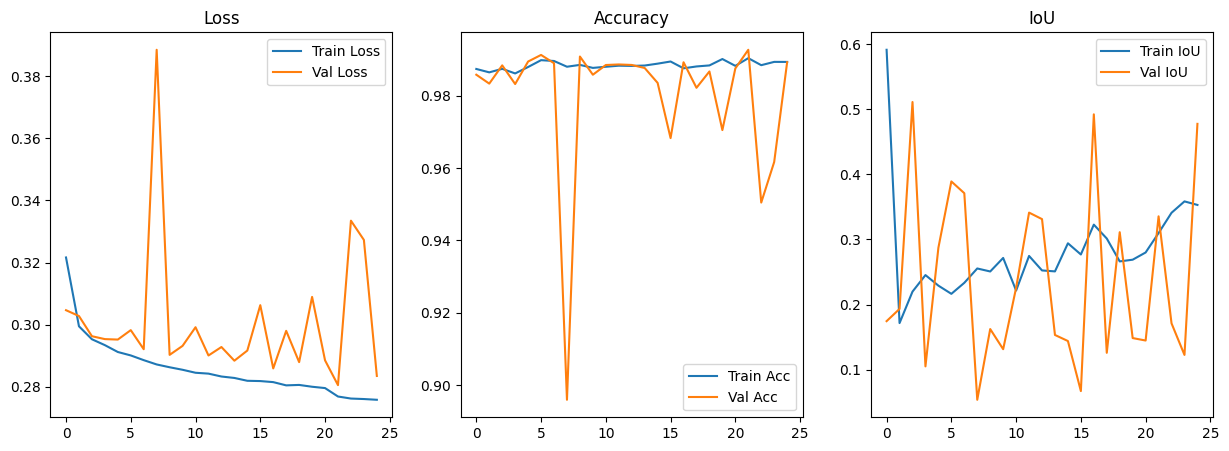

In [ ]:
plot_train_curves(res34_history, save_path=plots_save_path, model_name="Unet_resnet34")

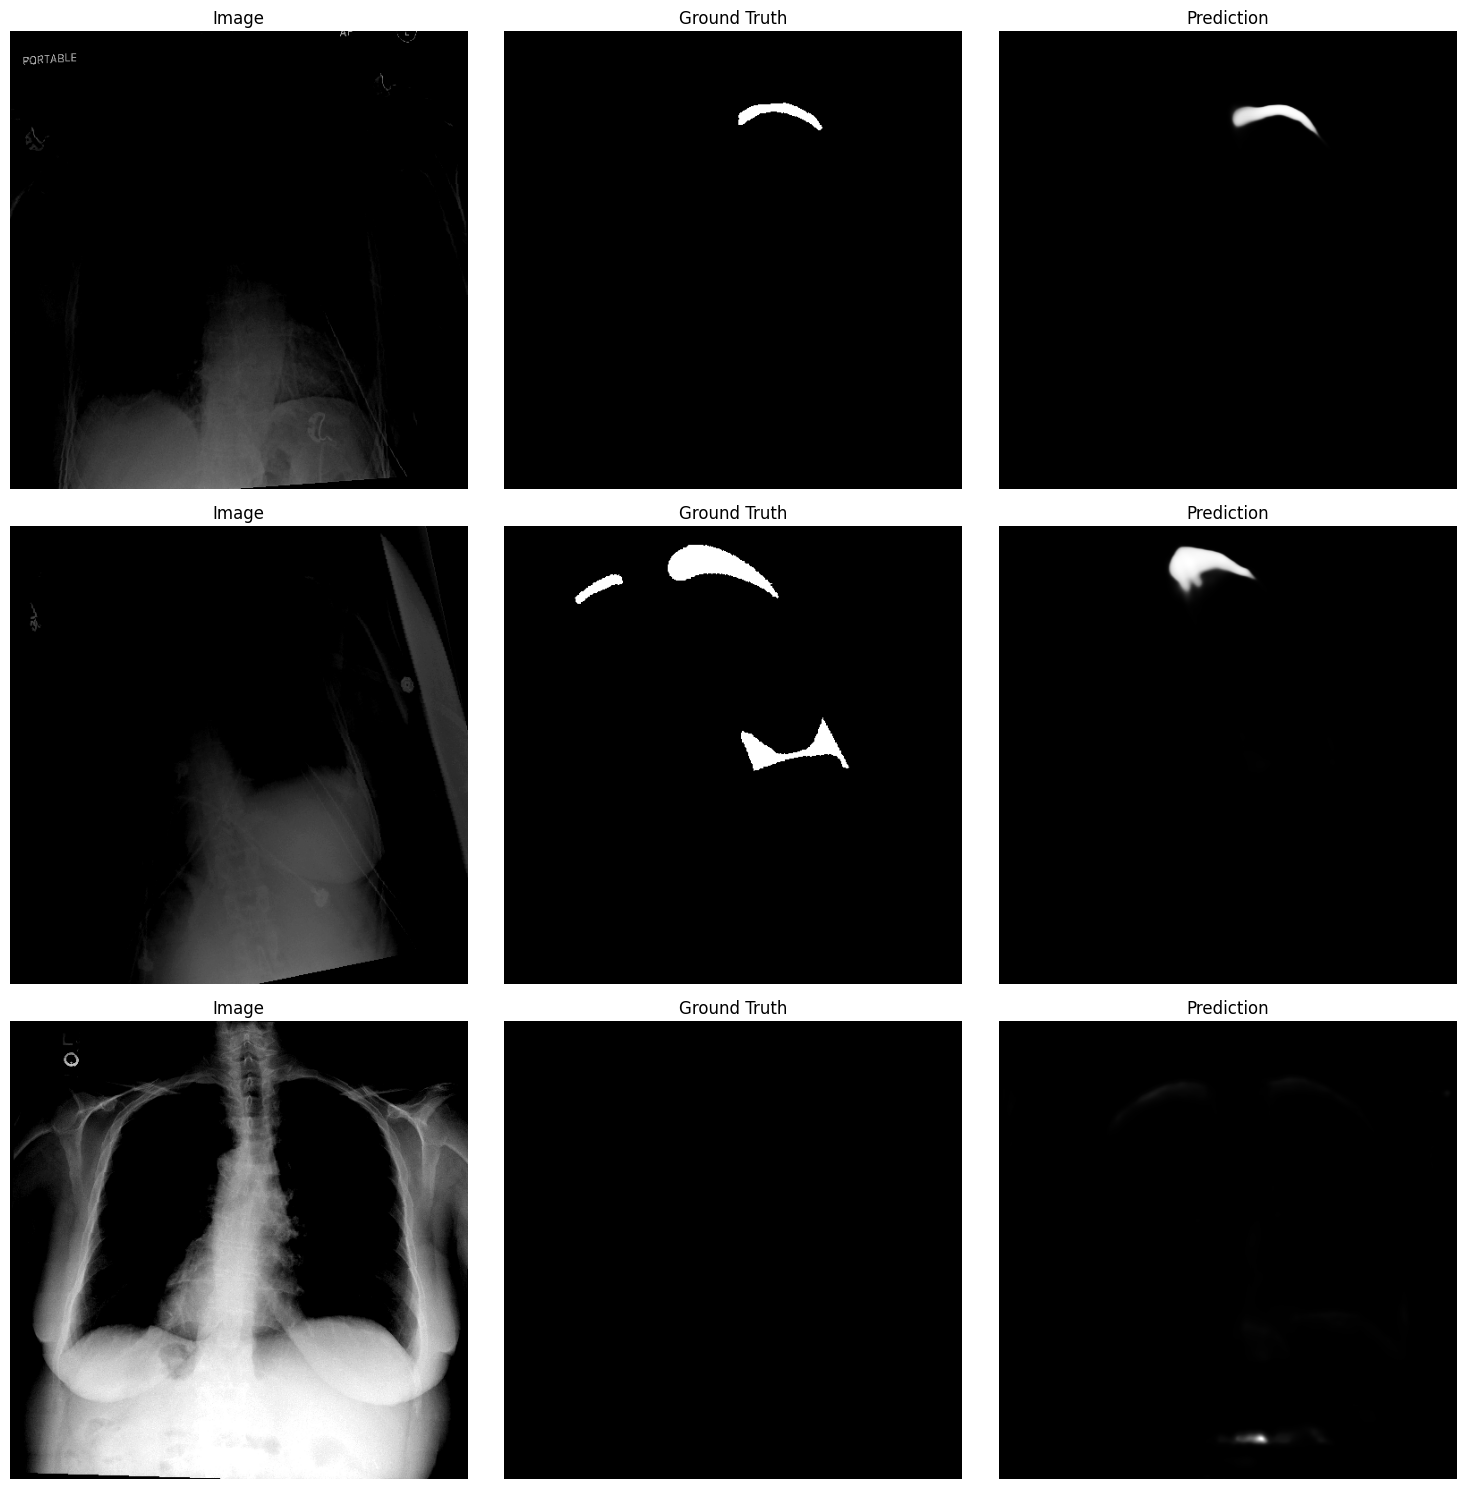

In [ ]:
show_predictions(res34_model, test_loader, CONF['device'], save_path=plots_save_path, model_name="Unet_resnet34", save_fig=True)

## Unet with VGG16 Results

In [ ]:
vgg16_model = torch.load(os.path.join(MAIN_PATH, "models", "Unet_vgg16_model_pytorch_2024-09-24 14:28:06.855349.pt"))
vgg16_history = pd.read_csv(os.path.join(MAIN_PATH, "histories", "Unet_vgg16_train_history_2024-09-24 14:28:07.076848.csv"))

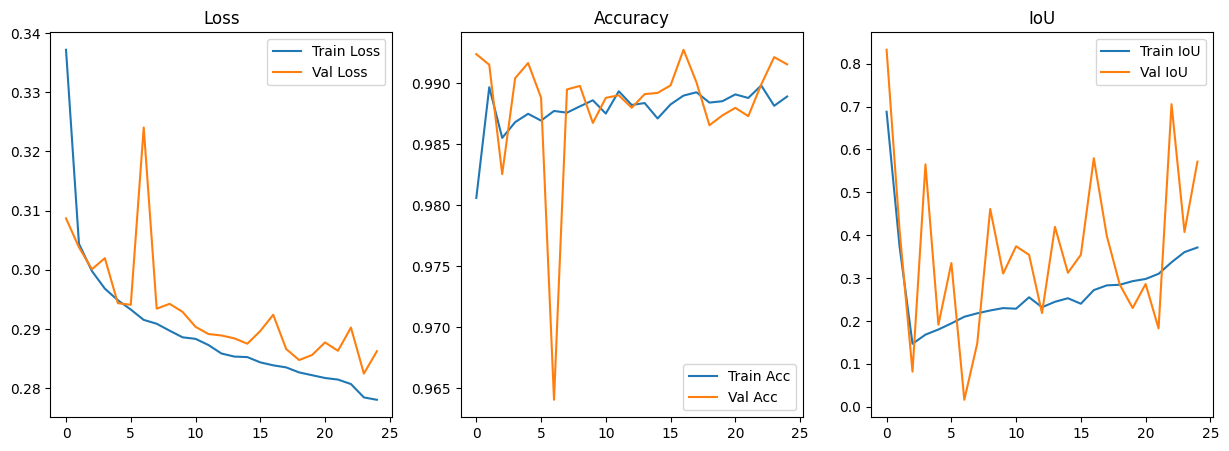

In [ ]:
plot_train_curves(vgg16_history, save_path=plots_save_path, model_name="Unet_vgg16")

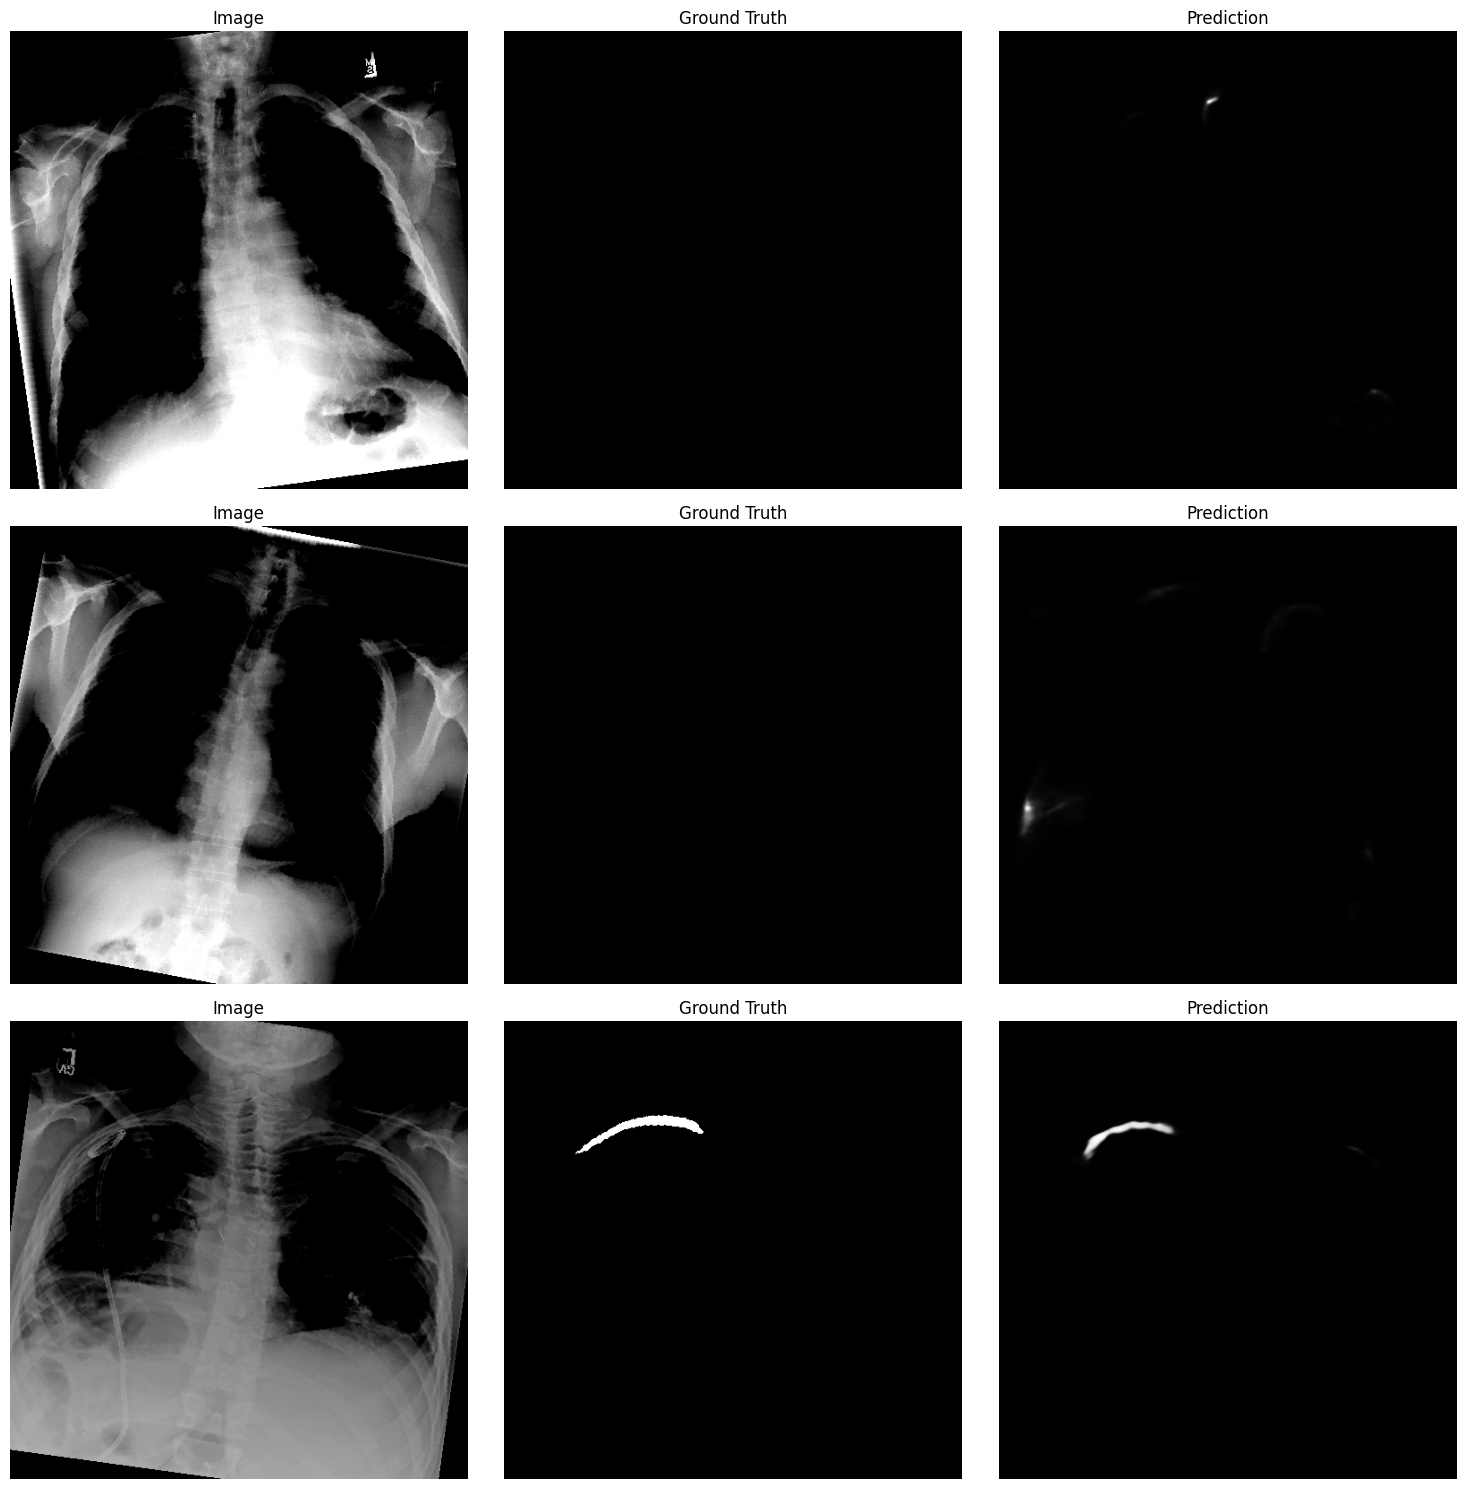

In [ ]:
show_predictions(vgg16_model, test_loader, CONF['device'], save_path=plots_save_path, model_name="Unet_vgg16", save_fig=True)

## Unet with InceptionResNetV2 Results

In [ ]:
incepv2_model = torch.load(os.path.join(MAIN_PATH, "models", "Unet_inceptionresnetv2_model_pytorch_2024-09-25 11:19:54.171532.pt"))
incepv2_history = pd.read_csv(os.path.join(MAIN_PATH, "histories", "Unet_inceptionresnetv2_train_history_2024-09-25 11:19:54.912321.csv"))

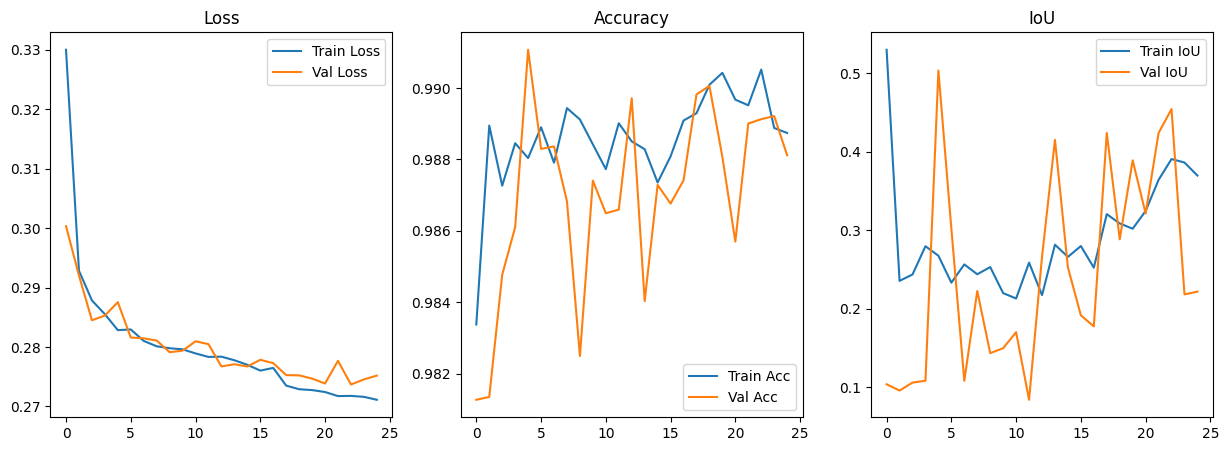

In [ ]:
plot_train_curves(incepv2_history, save_path=plots_save_path, model_name="Unet_inceptionresnetv2")

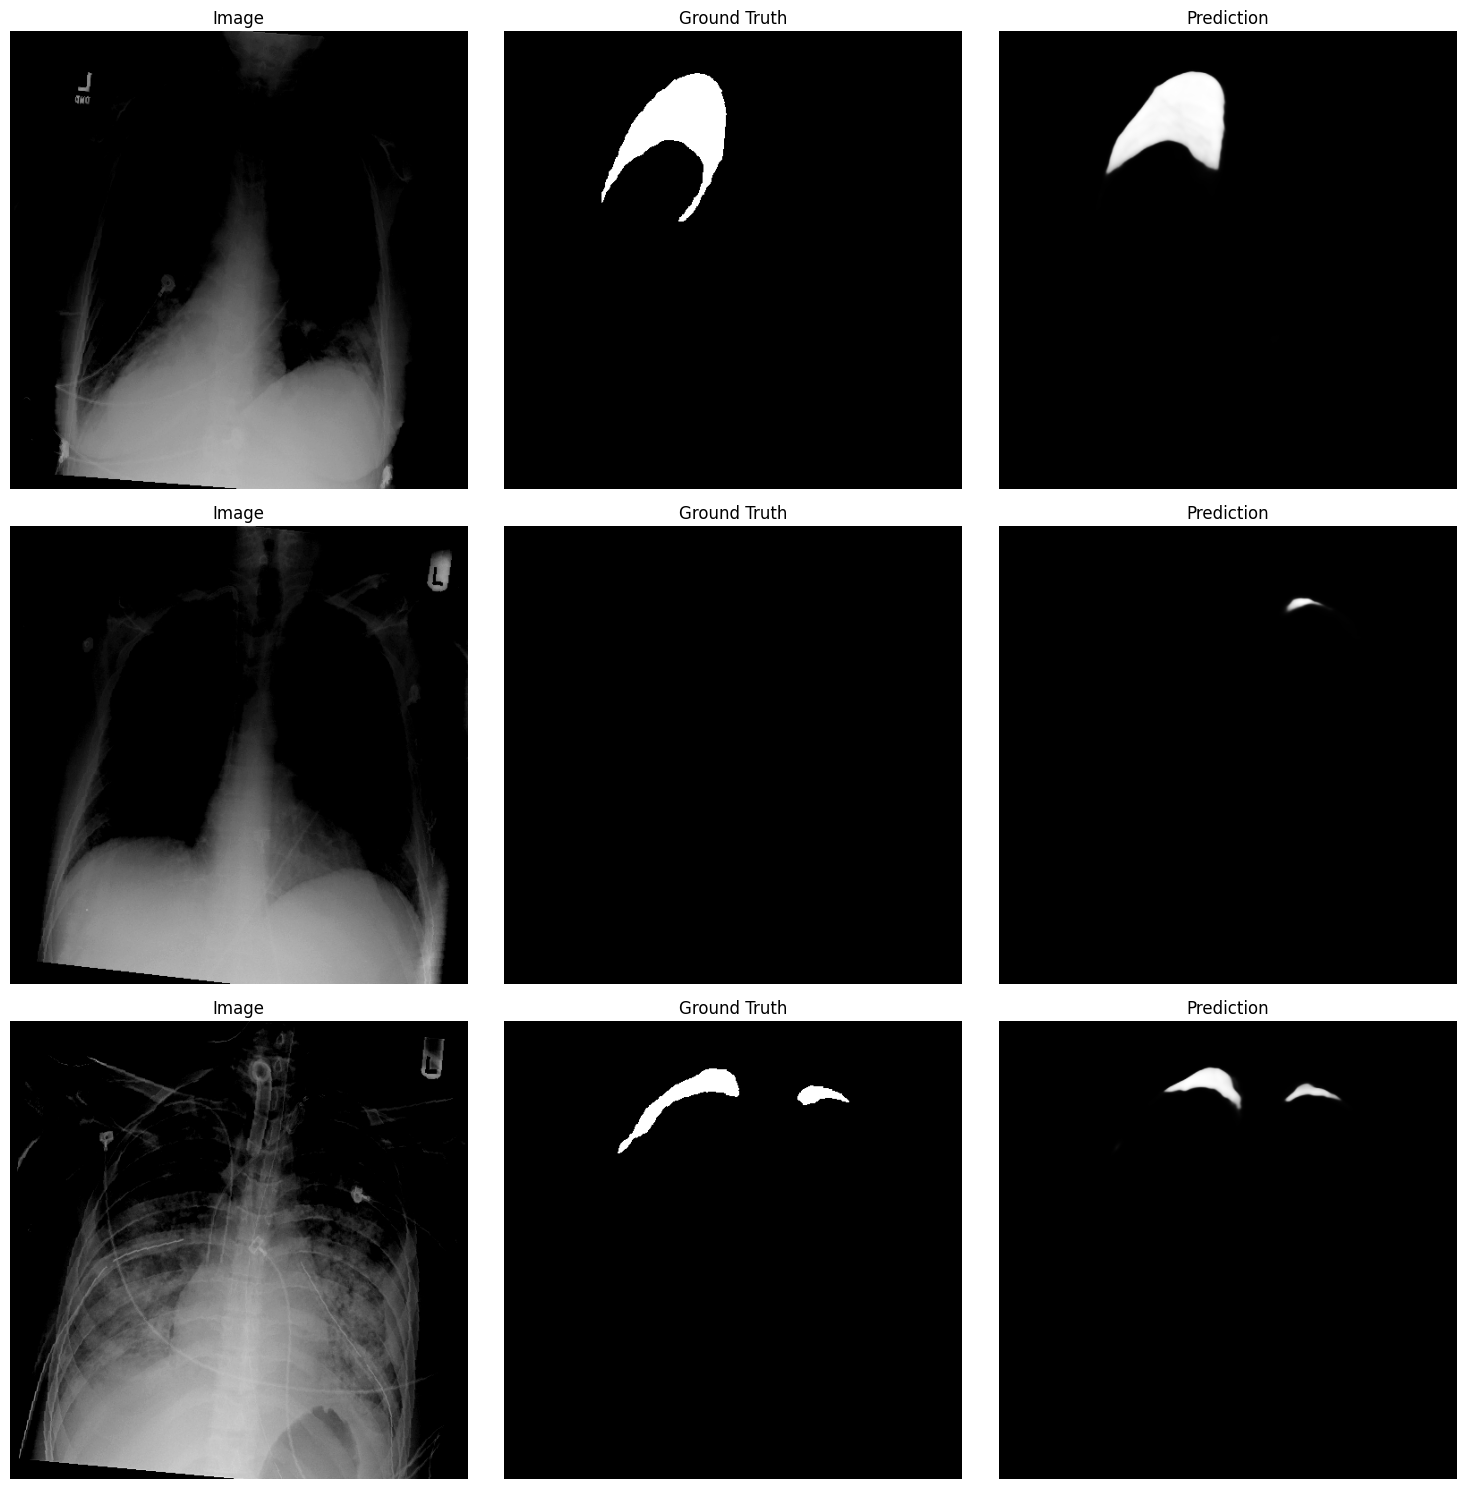

In [ ]:
show_predictions(incepv2_model, test_loader, CONF['device'], save_path=plots_save_path, model_name="Unet_inceptionresnetv2", save_fig=True)

## Unet with Xception Results

In [ ]:
xcep_model = torch.load(os.path.join(MAIN_PATH, "models", "Unet_xception_model_pytorch_2024-09-25 13:51:18.439717.pt"))
xcep_history = pd.read_csv(os.path.join(MAIN_PATH, "histories", "Unet_xception_train_history_2024-09-25 13:51:18.748141.csv"))

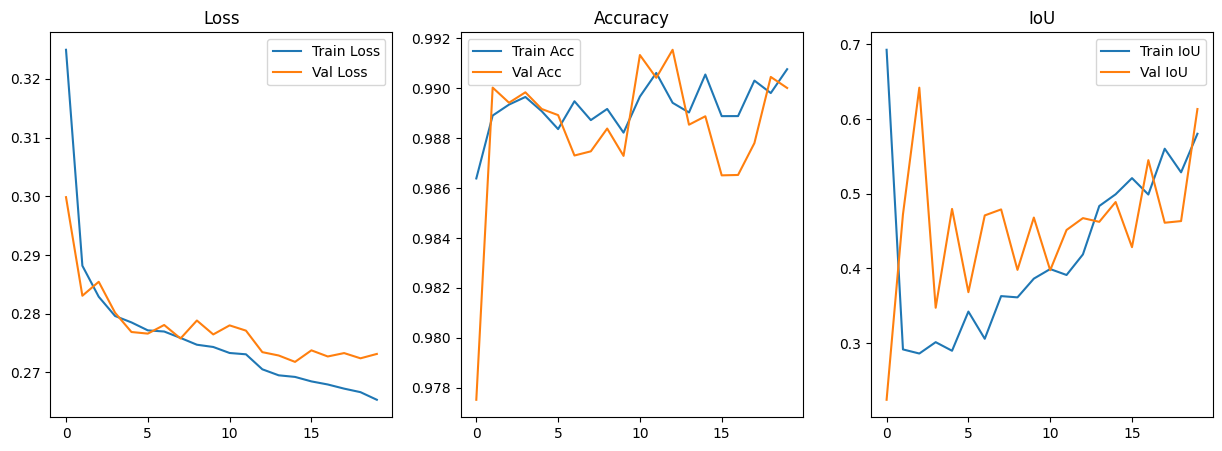

In [ ]:
plot_train_curves(xcep_history, save_path=plots_save_path, model_name="Unet_xception")

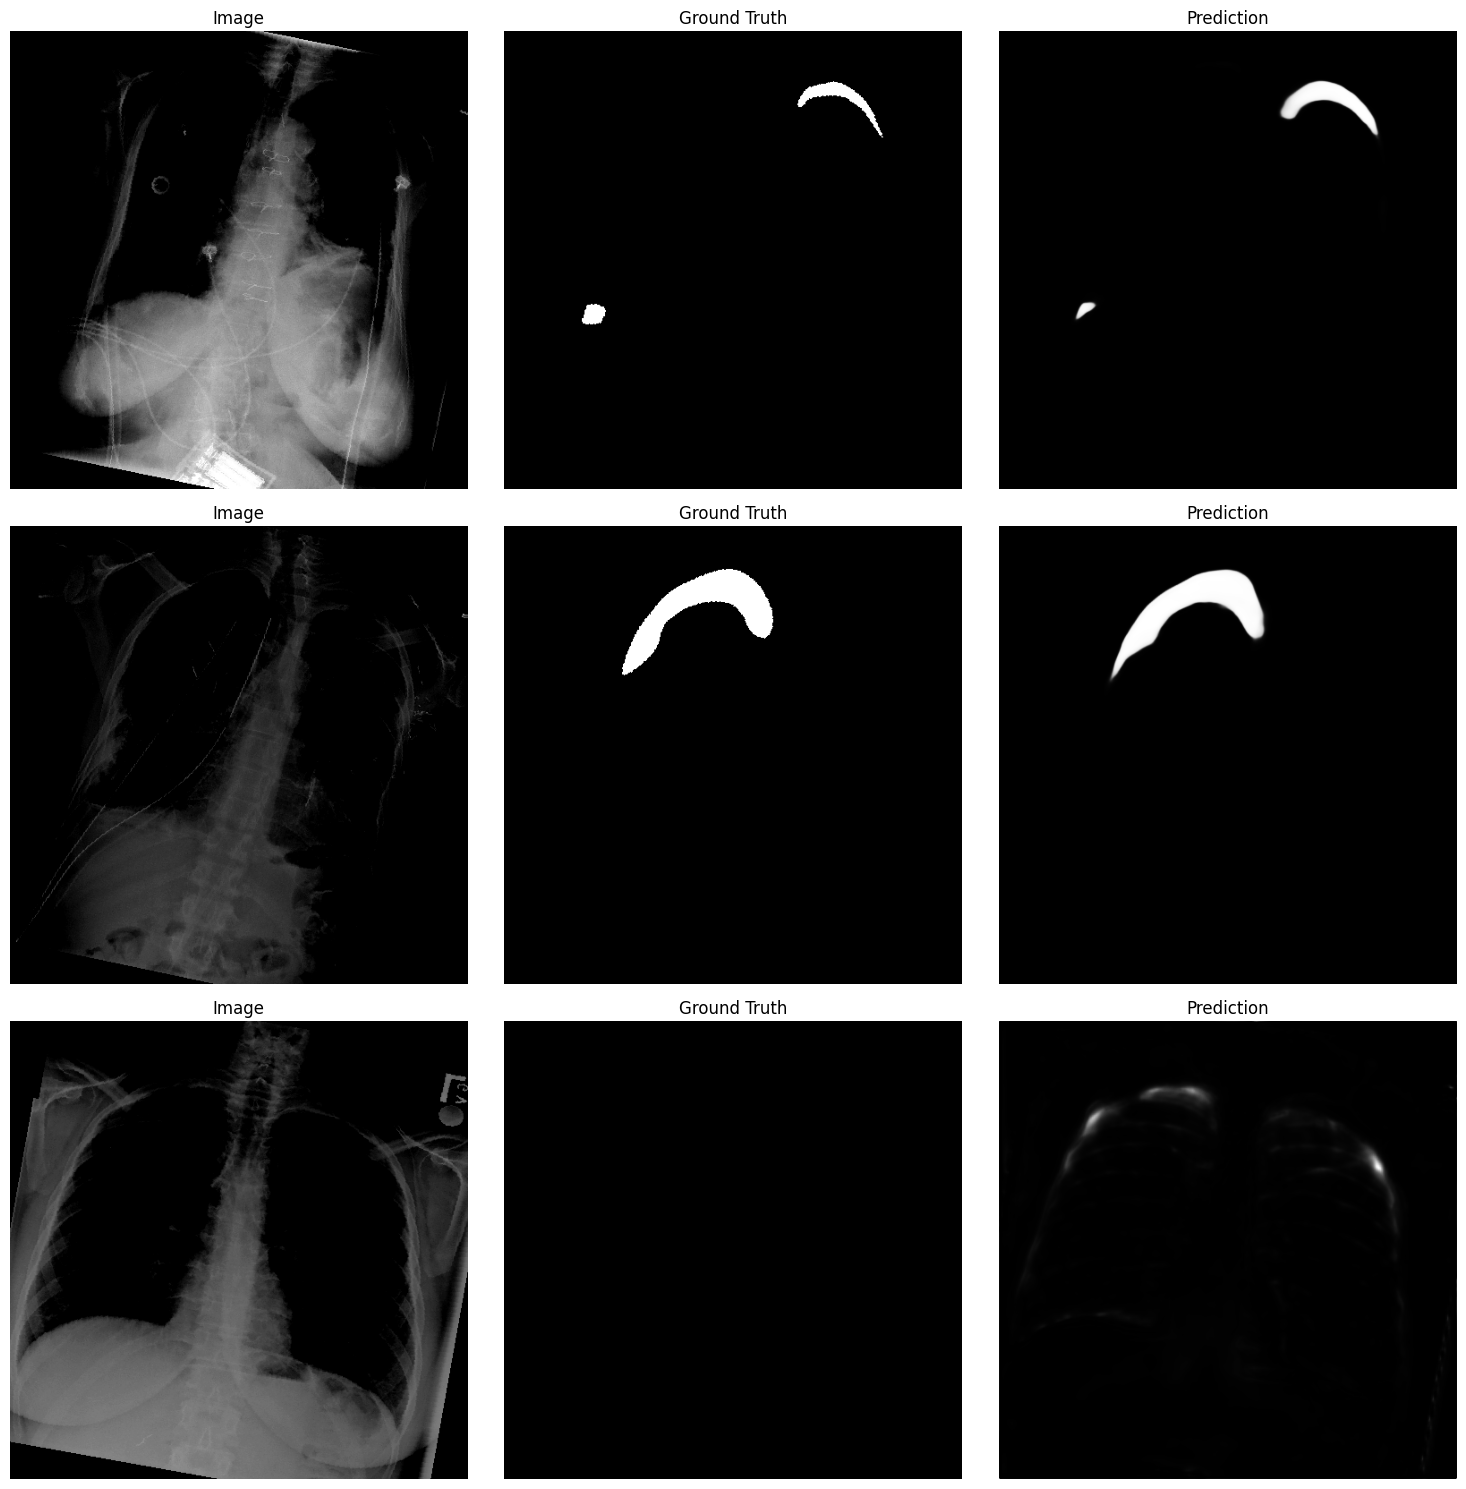

In [ ]:
show_predictions(xcep_model, test_loader, CONF['device'], save_path=plots_save_path, model_name="Unet_xception", save_fig=True)

##Evaluation

In [ ]:
import torch
import torch.nn.functional as F

def evaluate_model(model, test_loader, device, combined_loss):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_iou_score = 0.0
    total_accuracy = 0.0
    num_batches = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, masks, _ in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass to get model predictions
            outputs = model(images)

            # Calculate the loss using your combined loss function
            loss = combined_loss(outputs, masks)
            total_loss += loss.item()
            # print("total loss " + str(num_batches) + " " + str(total_loss))

            # Apply sigmoid activation to get probabilities
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()  # Convert to binary mask (0 or 1)

            # Calculate Intersection over Union (IoU)
            iou = iou_metric(preds,masks).item()
            # print("iou " + str(num_batches) + " " + str(iou))


            # Calculate pixel-wise accuracy
            accuracy = accuracy_metric(preds,masks).mean().item()
            # print("accuracy " + str(num_batches) + " " + str(accuracy))

            total_iou_score += iou
            total_accuracy += accuracy
            num_batches += 1
            print("batch "+ str(num_batches) + " evaluated.")

    # Print the averaged results
    avg_loss = total_loss / num_batches
    avg_iou = total_iou_score / num_batches
    avg_accuracy = total_accuracy / num_batches

    print(f"Model Evaluation Results on Test Set:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Average IoU Score: {avg_iou:.4f}")
    print(f"Average Accuracy: {avg_accuracy:.4f}")


In [ ]:
evaluate_model(res34_model, test_loader, CONF['device'], combined_loss)

batch 1 evaluated.
batch 2 evaluated.
batch 3 evaluated.
batch 4 evaluated.
batch 5 evaluated.
batch 6 evaluated.
batch 7 evaluated.
batch 8 evaluated.
batch 9 evaluated.
batch 10 evaluated.
batch 11 evaluated.
batch 12 evaluated.
batch 13 evaluated.
batch 14 evaluated.
batch 15 evaluated.
Model Evaluation Results on Test Set:
Average Loss: 0.2761
Average IoU Score: 0.4733
Average Accuracy: 0.9885


In [ ]:
evaluate_model(vgg16_model, test_loader, CONF['device'], combined_loss)

batch 1 evaluated.
batch 2 evaluated.
batch 3 evaluated.
batch 4 evaluated.
batch 5 evaluated.
batch 6 evaluated.
batch 7 evaluated.
batch 8 evaluated.
batch 9 evaluated.
batch 10 evaluated.
batch 11 evaluated.
batch 12 evaluated.
batch 13 evaluated.
batch 14 evaluated.
batch 15 evaluated.
Model Evaluation Results on Test Set:
Average Loss: 0.2811
Average IoU Score: 0.5504
Average Accuracy: 0.9928


In [ ]:
evaluate_model(incepv2_model, test_loader, CONF['device'], combined_loss)

batch 1 evaluated.
batch 2 evaluated.
batch 3 evaluated.
batch 4 evaluated.
batch 5 evaluated.
batch 6 evaluated.
batch 7 evaluated.
batch 8 evaluated.
batch 9 evaluated.
batch 10 evaluated.
batch 11 evaluated.
batch 12 evaluated.
batch 13 evaluated.
batch 14 evaluated.
batch 15 evaluated.
Model Evaluation Results on Test Set:
Average Loss: 0.2718
Average IoU Score: 0.2238
Average Accuracy: 0.9943


In [ ]:
evaluate_model(xcep_model, test_loader, CONF['device'], combined_loss)

batch 1 evaluated.
batch 2 evaluated.
batch 3 evaluated.
batch 4 evaluated.
batch 5 evaluated.
batch 6 evaluated.
batch 7 evaluated.
batch 8 evaluated.
batch 9 evaluated.
batch 10 evaluated.
batch 11 evaluated.
batch 12 evaluated.
batch 13 evaluated.
batch 14 evaluated.
batch 15 evaluated.
Model Evaluation Results on Test Set:
Average Loss: 0.2674
Average IoU Score: 0.6085
Average Accuracy: 0.9920


#Feature Extraction

In [ ]:
# Function to get predicted masks from the segmentation model
def get_predicted_masks(model, dataloader, device):
    model.eval()
    true_labels = []  # Assuming you have true labels for classification
    outputs = []

    with torch.no_grad():
        for images, masks, labels in dataloader:  # Assuming the dataloader gives images and true labels
            images = images.to(device)
            preds = model(images)
            for img, pred, label in zip(images, preds, labels):
              pred = torch.sigmoid(pred)
              pred = torch.round(pred)

              output = np.multiply(img.cpu().numpy(), pred.cpu().numpy())
              output = np.squeeze(output)

              outputs.append(output)
              true_labels.append(label.cpu().item())

    return outputs, true_labels


In [ ]:
# Step 1: Get the predicted masks from the segmentation model
train_outputs, train_labels = get_predicted_masks(xcep_model, train_loader, CONF["device"])
test_outputs, test_labels = get_predicted_masks(xcep_model, test_loader, CONF["device"])
valid_outputs, valid_labels = get_predicted_masks(xcep_model, val_loader, CONF["device"])

In [ ]:
train_fx_loader = DataLoader(torch.Tensor(train_outputs), batch_size=CONF['batch_size'])
test_fx_loader = DataLoader(torch.Tensor(test_outputs), batch_size=CONF['batch_size'])
valid_fx_loader = DataLoader(torch.Tensor(valid_outputs), batch_size=CONF['batch_size'])

In [ ]:
from torchvision import models
class BinaryImageClassifier(nn.Module):
    def __init__(self, pretrained_model='densenet', num_classes=1):
        super(BinaryImageClassifier, self).__init__()
        self.model = models.__dict__[pretrained_model](pretrained=True)

        # Modify the final fully connected layer for binary classification
        if 'resnet' in pretrained_model:
            self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        elif 'densenet' in pretrained_model:
            self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)

        self.sigmoid = nn.Sigmoid()  # For binary classification

    def forward(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x

In [ ]:
model = BinaryImageClassifier(pretrained_model='densenet', num_classes=1)

In [ ]:
def train_classifier_with_features(model, train_features, train_labels, val_features, val_labels, num_epochs=10, lr=1e-3, device='cuda'):
    criterion = nn.BCELoss()  # Binary cross entropy loss for binary classification
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model = model.to(device)

    # Track history
    train_losses = []
    val_losses = []

    train_features = torch.Tensor(train_features).to(device)
    train_labels = torch.Tensor(train_labels).to(device)
    val_features = torch.Tensor(val_features).to(device)
    val_labels = torch.Tensor(val_labels).to(device)

    for epoch in range(num_epochs):
        model.train()

        # Forward pass with training features
        outputs = model(train_features)
        loss = criterion(outputs, train_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record training loss
        train_losses.append(loss.item())

        # Validation step
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_features)
            val_loss = criterion(val_outputs, val_labels)
            val_losses.append(val_loss.item())

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Return the trained model and the history of losses
    history = {'train_loss': train_losses, 'val_loss': val_losses}
    return model, history

In [ ]:
import torchvision
model_name = 'densenet121'
layer_name = 'features'

# If you want to use other models such as resnet18, uncomment lines below
#model_name = 'resnet18'
#layer_name = 'avgpool'

get_model = getattr(torchvision.models, model_name)

def extract_features(images, device):

    model = get_model(pretrained=True)
    model = model.to(device)
    model.eval()

    # register hook to access to features in forward pass
    features = []
    def hook(module, input, output):
        N,C,H,W = output.shape
        output = output.reshape(N,C,-1)
        features.append(output.mean(dim=2).cpu().detach().numpy())
    handle = model._modules.get(layer_name).register_forward_hook(hook)

    for i_batch, inputs in tqdm(enumerate(images), total=len(images)):
      _ = model(inputs.to(device))

    features = np.concatenate(features)

    features = pd.DataFrame(features)
    features = features.add_prefix('IMAGE_')

    handle.remove()
    del model

    return features

In [ ]:
train_features = extract_features(train_fx_loader, CONF["device"])
test_features = extract_features(test_fx_loader, CONF["device"])
valid_features = extract_features(valid_fx_loader, CONF["device"])

In [ ]:
pd.DataFrame(train_labels).to_csv(os.path.join(MAIN_PATH, "training_labels.csv"))
pd.DataFrame(test_labels).to_csv(os.path.join(MAIN_PATH, "testing_labels.csv"))
pd.DataFrame(valid_labels).to_csv(os.path.join(MAIN_PATH "validation_labels.csv"))

train_features.to_csv(os.path.join(MAIN_PATH, "training_features.csv"))
test_features.to_csv(os.path.join(MAIN_PATH, "testing_features.csv"))
valid_features.to_csv(os.path.join(MAIN_PATH, "validation_features.csv"))

In [ ]:
train_features = pd.read_csv(os.path.join(MAIN_PATH, "training_features.csv"))
test_features = pd.read_csv(os.path.join(MAIN_PATH, "testing_features.csv"))
valid_features = pd.read_csv(os.path.join(MAIN_PATH, "validation_features.csv"))

train_labels = pd.read_csv(os.path.join(MAIN_PATH, "training_labels.csv"))
test_labels = pd.read_csv(os.path.join(MAIN_PATH, "testing_labels.csv"))
valid_labels = pd.read_csv(os.path.join(MAIN_PATH, "validaton_labels.csv"))

In [ ]:
train_features.values

array([[ 2.3000193e-04, -2.4217151e-03,  3.6189484e-03, ...,
         2.5429505e-01, -4.8128560e-02, -5.5131567e-01],
       [ 2.8567784e-04, -3.1019934e-03,  3.5825246e-03, ...,
         3.2820517e-01,  8.1421807e-02, -5.2194256e-01],
       [ 2.8465668e-04, -3.1582974e-03,  3.6017830e-03, ...,
         6.2309712e-01,  1.4230469e-01, -5.3053951e-01],
       ...,
       [ 3.1185558e-04, -3.8230692e-03,  3.6205237e-03, ...,
         3.8758926e-02,  5.7379656e-02, -5.6398332e-01],
       [ 2.7810951e-04, -3.4126621e-03,  3.4567961e-03, ...,
         7.7935117e-01,  2.4019217e-01, -5.3704071e-01],
       [ 3.1185558e-04, -3.8230692e-03,  3.6205237e-03, ...,
         3.8758926e-02,  5.7379656e-02, -5.6398332e-01]], dtype=float32)

# Classification

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
import seaborn as sns

In [ ]:
# Define the evaluation log
evals_result = {}

# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.01,
    max_depth=6,
    eval_metric=["logloss", "error"]  # Track loss and error (for accuracy)
)

# Fit the model and track evaluation results
xgb_clf.fit(
    train_features,
    train_labels,
    eval_set=[(train_features, train_labels), (valid_features, valid_labels)],
    verbose=True,
)


[0]	validation_0-logloss:0.52272	validation_0-error:0.22023	validation_1-logloss:0.52664	validation_1-error:0.22302
[1]	validation_0-logloss:0.51653	validation_0-error:0.22023	validation_1-logloss:0.52127	validation_1-error:0.22302
[2]	validation_0-logloss:0.51051	validation_0-error:0.22023	validation_1-logloss:0.51590	validation_1-error:0.22302
[3]	validation_0-logloss:0.50461	validation_0-error:0.22023	validation_1-logloss:0.51087	validation_1-error:0.22302
[4]	validation_0-logloss:0.49888	validation_0-error:0.22023	validation_1-logloss:0.50579	validation_1-error:0.22302
[5]	validation_0-logloss:0.49330	validation_0-error:0.22023	validation_1-logloss:0.50084	validation_1-error:0.22302
[6]	validation_0-logloss:0.48775	validation_0-error:0.22023	validation_1-logloss:0.49602	validation_1-error:0.22302
[7]	validation_0-logloss:0.48248	validation_0-error:0.22023	validation_1-logloss:0.49127	validation_1-error:0.22302
[8]	validation_0-logloss:0.47733	validation_0-error:0.22023	validation_1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['logloss', 'error'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Predict on the test set
y_pred = xgb_clf.predict(test_features)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_labels, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1399
           1       0.85      0.64      0.73       409

    accuracy                           0.89      1808
   macro avg       0.88      0.80      0.83      1808
weighted avg       0.89      0.89      0.89      1808



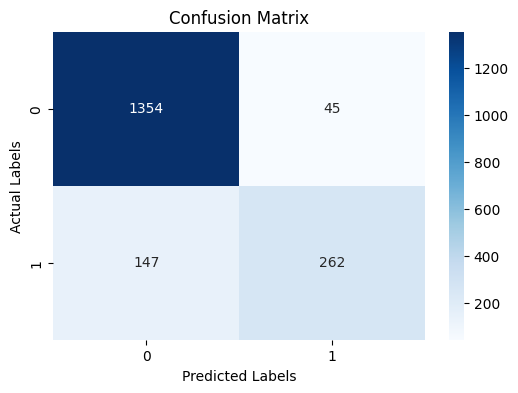

In [ ]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

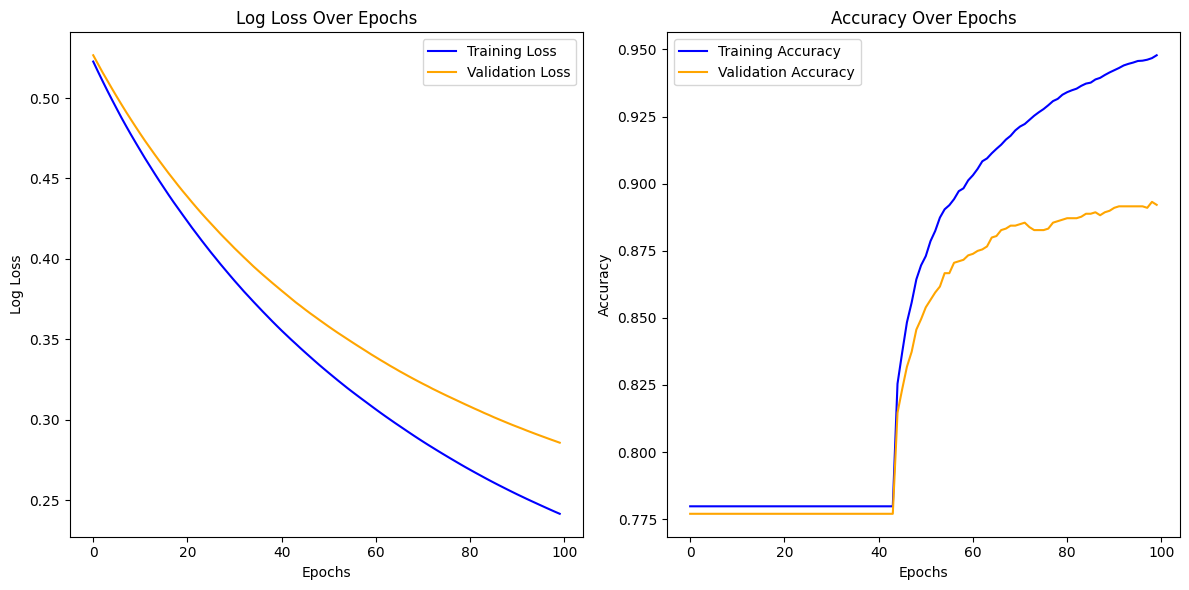

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(evals_result):
    """
    Plots the training and validation loss and accuracy curves from XGBoost evaluation results.

    Args:
        evals_result (dict): Dictionary containing evaluation results of XGBoost training.
    """
    # Extract data for plotting
    train_logloss = evals_result['validation_0']['logloss']
    valid_logloss = evals_result['validation_1']['logloss']
    train_error = evals_result['validation_0']['error']
    valid_error = evals_result['validation_1']['error']

    # Convert error to accuracy (1 - error rate)
    train_accuracy = [1 - e for e in train_error]
    valid_accuracy = [1 - e for e in valid_error]

    # Plot the log loss (cross-entropy loss) curves
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)  # Loss subplot
    plt.plot(train_logloss, label="Training Loss", color="blue")
    plt.plot(valid_logloss, label="Validation Loss", color="orange")
    plt.title('Log Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.legend()

    # Plot the accuracy curves
    plt.subplot(1, 2, 2)  # Accuracy subplot
    plt.plot(train_accuracy, label="Training Accuracy", color="blue")
    plt.plot(valid_accuracy, label="Validation Accuracy", color="orange")
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage after training:
plot_learning_curves(xgb_clf.evals_result())

## Hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': np.arange(50, 1000, 50),
    'max_depth': np.arange(10, 20, 1),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.4, 0.5],
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings to sample
    scoring='recall',  # Evaluation metric
    n_jobs=-1,  # Use all available processors
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42
)

In [ ]:
# Perform random search
random_search.fit(train_features, train_labels)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=['logloss', 'error'],
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=Non...
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.001, 0.01, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,
       700, 750, 800, 850, 900, 950]),
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='recall', verbose=2)

In [ ]:
# Get the best estimator
best_model = random_search.best_estimator_

# Print the best parameters found by random search
print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 17, 'learning_rate': 0.2, 'gamma': 0.4, 'colsample_bytree': 1.0}


In [ ]:
best_model.fit(
    train_features,
    train_labels,
    eval_set=[(train_features, train_labels), (valid_features, valid_labels)],
    verbose=True,
)

[0]	validation_0-logloss:0.40094	validation_0-error:0.22023	validation_1-logloss:0.43881	validation_1-error:0.22302
[1]	validation_0-logloss:0.32157	validation_0-error:0.08752	validation_1-logloss:0.38196	validation_1-error:0.13171
[2]	validation_0-logloss:0.26503	validation_0-error:0.05005	validation_1-logloss:0.34161	validation_1-error:0.12396
[3]	validation_0-logloss:0.22260	validation_0-error:0.02502	validation_1-logloss:0.31320	validation_1-error:0.12064
[4]	validation_0-logloss:0.18981	validation_0-error:0.01435	validation_1-logloss:0.29382	validation_1-error:0.11566
[5]	validation_0-logloss:0.16374	validation_0-error:0.01186	validation_1-logloss:0.27601	validation_1-error:0.11013
[6]	validation_0-logloss:0.14280	validation_0-error:0.00972	validation_1-logloss:0.26433	validation_1-error:0.10459
[7]	validation_0-logloss:0.12565	validation_0-error:0.00806	validation_1-logloss:0.25440	validation_1-error:0.10349
[8]	validation_0-logloss:0.11207	validation_0-error:0.00759	validation_1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['logloss', 'error'],
              feature_types=None, gamma=0.4, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=17,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Evaluate on the test set
test_preds = best_model.predict(test_features)

# Classification report
print("Classification Report:\n", classification_report(test_labels, test_preds))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      1399
           1       0.81      0.76      0.78       409

    accuracy                           0.90      1808
   macro avg       0.87      0.85      0.86      1808
weighted avg       0.90      0.90      0.90      1808



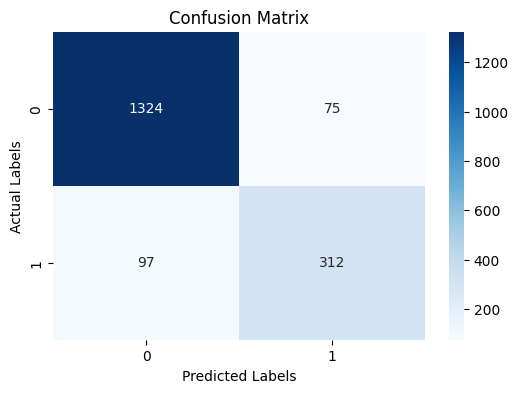

In [ ]:
conf_matrix = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

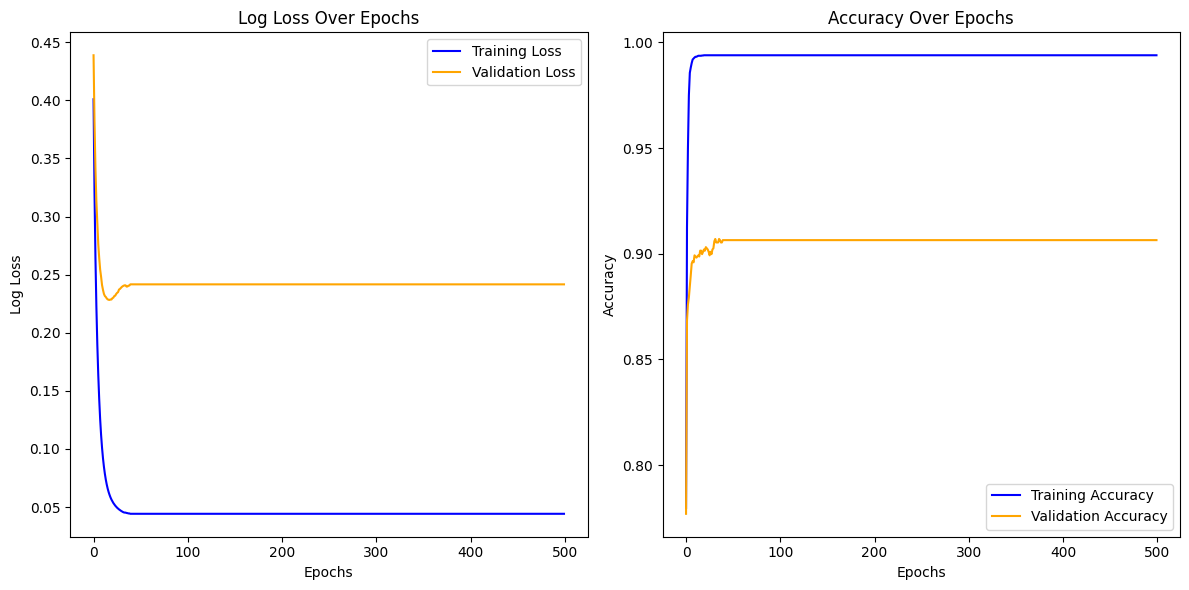

In [ ]:
plot_learning_curves(best_model.evals_result())